In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch, gc
gc.collect()
torch.cuda.empty_cache()
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, utils

In [2]:
import matplotlib.pyplot as plt # plotting
from PIL import Image
import matplotlib.patches as patches
import matplotlib.image as IMG
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.io

In [3]:
#https://www.kaggle.com/armannikkhah/hand-dataset
images_path = Path('D:/GeekBrains/pytorch/les06/data/hand_detect/images')
anno_path = Path('D:/GeekBrains/pytorch/les06/data/hand_detect/annotations')

In [4]:
def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def mat_to_boundbox(filename):
    input = scipy.io.loadmat(filename)['boxes']
    box_numbers = input.shape[-1]
    bx1_e1 = input[0][0][0][0][0][0]
    bx1_e2 = input[0][0][0][0][1][0]
    bx1_e3 = input[0][0][0][0][2][0]
    bx1_e4 = input[0][0][0][0][3][0]
    bx1 = np.array([bx1_e1,bx1_e2,bx1_e3,bx1_e4])
    bx1 = [[b if b >= 0 else 0 for b in bx] for bx in bx1]
    bx1 = np.flip(bx1,1)
    boxes1 = [int(round(min(bx1.T[0]))), int(round(min(bx1.T[1]))), int(round(max(bx1.T[0]))), int(round(max(bx1.T[1])))]
    output = [boxes1]

    if box_numbers == 2:
        bx2_e1 = input[0][1][0][0][0][0]
        bx2_e2 = input[0][1][0][0][1][0]
        bx2_e3 = input[0][1][0][0][2][0]
        bx2_e4 = input[0][1][0][0][3][0]
        bx2 = np.array([bx2_e1,bx2_e2,bx2_e3,bx2_e4])
        bx2 = [[b if b >= 0 else 0 for b in bx] for bx in bx2]
        bx2 = np.flip(bx2,1)
        boxes2 = [int(round(min(bx2.T[0]))), int(round(min(bx2.T[1]))), int(round(max(bx2.T[0]))), int(round(max(bx2.T[1])))]
        output = np.array([boxes1,boxes2])
   
    return output

def generate_train_df(anno_path):
    annotations = filelist(anno_path, '.mat')
    anno_list = []
    for anno_path in annotations:
        anno = {}
        anno['filename'] = Path(os.path.splitext(str(images_path) + '/'+ str(Path(anno_path).parts[-1]))[:-1][0] + '.jpg')
        anno['class'] = 0
        anno['bbox'] = mat_to_boundbox(anno_path)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [5]:
hands_df = generate_train_df(anno_path)
hands_df.head()

,filename,class,bbox
0,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[346, 462, 387, 492], [384, 450, 427, 493]]"
1,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[131, 371, 171, 411], [228, 370, 282, 419]]"
2,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[146, 381, 191, 426], [264, 346, 318, 396]]"
3,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[231, 360, 279, 405]]"
4,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[319, 347, 366, 394]]"


In [6]:
hands_df.to_csv('hands_df.csv', sep = ';')

In [7]:
hands_df.head(20)

,filename,class,bbox
0,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[346, 462, 387, 492], [384, 450, 427, 493]]"
1,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[131, 371, 171, 411], [228, 370, 282, 419]]"
2,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[146, 381, 191, 426], [264, 346, 318, 396]]"
3,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[231, 360, 279, 405]]"
4,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[319, 347, 366, 394]]"
5,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[379, 380, 426, 425]]"
6,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[199, 501, 248, 566], [373, 521, 411, 571]]"
7,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[184, 482, 245, 549], [392, 504, 430, 552]]"
8,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[186, 483, 250, 547], [392, 507, 439, 564]]"
9,D:\GeekBrains\pytorch\les06\data\hand_detect\i...,0,"[[179, 469, 239, 540], [377, 513, 412, 562]]"


In [8]:
hands_df['filename'][20]

WindowsPath('D:/GeekBrains/pytorch/les06/data/hand_detect/images/Buffy_117.jpg')

In [9]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [10]:
def show_corner_bb(im, bb):
    plt.imshow(im)
    for box in bb:
        plt_box = plt.Rectangle( (box[0], box[1]),
                        box[2] - box[0],
                        box[3] - box[1], 
                        color='red',
                         fill=False, lw=3)
        plt.gca().add_patch(plt_box)

D:\GeekBrains\pytorch\les06\data\hand_detect\images\Movie_4weds_13.jpg


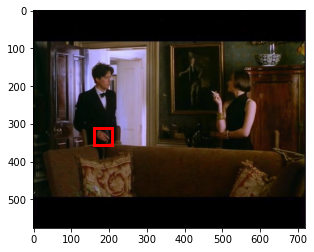

In [11]:
number = 1146

test_img = read_image(hands_df['filename'][number])
bb_boxs = hands_df['bbox'][number]
print(hands_df['filename'][number])
show_corner_bb(test_img, bb_boxs)

In [12]:
def create_mask(bb, x):
    """Создаем маску для обрамляющего прямоугольника такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = []        
    for b in bb:
        b = np.array(b)
        b = b.astype(np.int)
        mask = np.zeros((rows, cols))
        mask[b[1]:b[3], b[0]:b[2]] = 1.
        Y.append(mask)
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в обрамляющий прямоугольник, принимая 0 как фоновый ненулевой объект """
    list_of_boxes = []
    for mask in Y:
        cols, rows = np.nonzero(mask)
        if (len(cols)==0): 
            return np.zeros((1, 4), dtype=np.float32)
      
        top_row = np.min(cols)
        left_col = np.min(rows)
        bottom_row = np.max(cols)
        right_col = np.max(rows)
        list_of_boxes.append([left_col, top_row, right_col, bottom_row])
        
    return np.array(list_of_boxes, dtype=np.float32)

In [13]:
masks = create_mask(bb_boxs, test_img)

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


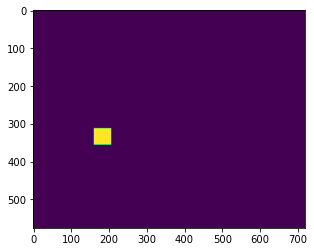

In [14]:
show_corner_bb(masks[0], [])

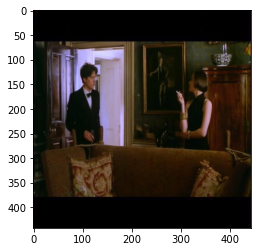

In [15]:
im_resized = cv2.resize(test_img, (442, 442))
show_corner_bb(im_resized, [])

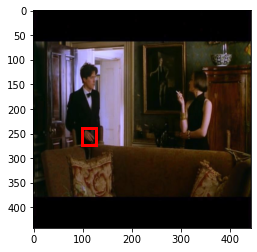

In [16]:
mask_0 = masks[0]
mask_0 = cv2.resize(mask_0, (442, 442))
bb_0 = mask_to_bb([mask_0])
show_corner_bb(im_resized, bb_0)

In [17]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Случайное вырезание части картинки
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [18]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Поворачиваем наше изображение"""
    if y:
        rotated_y = []
        for mask in im:
            r,c,*_ = mask.shape
            M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
            rotated_y.append(cv2.warpAffine(mask, M,(c,r), borderMode=cv2.BORDER_CONSTANT))
        return np.array(rotated_y)
    else:
        r,c,*_ = im.shape
        M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
        return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(im, bb, transforms):
    x = im #cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*15
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
#         if np.random.random() > 0.5: 
#             x = np.fliplr(x).copy()
#             Y = np.fliplr(Y).copy()
#         x, Y = random_cropXY(x, Y)
    return x, mask_to_bb(Y)

In [19]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

# def show_corner_bb(im, bb):
#     plt.imshow(im)
#     plt.gca().add_patch(create_corner_rect(bb))

In [20]:
def resize_image_bb(read_path,bb,sz):
    """Ресайзим изображение и его обрамляющий прямоугольник и записываем изображение в новый путь"""
    im = read_image(read_path)
    masks = create_mask(bb, im)
    
    resized_masks = []
    for m in masks:
        resized_masks.append(cv2.resize(m, (int(1.49*sz), sz)))
        
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    #new_path = str(write_path/read_path.parts[-1])
    #cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return im_resized, mask_to_bb(resized_masks)

In [21]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
import random

In [22]:
hands_df = hands_df.reset_index()
X = hands_df[['filename', 'bbox']]
Y = hands_df['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
class HandsDataset(Dataset):
    def __init__(self, filenames, bb, y, transforms=True):
        self.transforms = transforms
        self.paths = filenames.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        bb = self.bb[idx]
        y_class = self.y[idx]

        
        image, bb = resize_image_bb(path, bb, 400)
        image, y_bb = transformsXY(image, bb, False)
        image_id = torch.tensor([idx])
        image = np.rollaxis(image, 2)
        image_id = torch.tensor([idx])


        iscrowd = torch.zeros((len(bb),), dtype=torch.int64)
        labels = torch.ones((len(bb),), dtype=torch.int64)

        target = {}
        target["boxes"] = torch.from_numpy(y_bb.reshape(len(bb),4))
        target["labels"] = labels
        # Since you are training a target detection network, there is no target [masks] = masks in the tutorial
        target["image_id"] = image_id
        target["iscrowd"] = iscrowd

        return image, target

In [24]:
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [25]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_ds = HandsDataset(X_train['filename'],X_train['bbox'] ,y_train, get_train_transform)
valid_ds = HandsDataset(X_val['filename'],X_val['bbox'],y_val, get_valid_transform)


# split the dataset in train and test set
indices = torch.randperm(len(train_ds)).tolist()

train_data_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [26]:
sample = iter(train_data_loader).next()
sample[1]

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


({'boxes': tensor([[397., 238., 437., 261.]]),
  'labels': tensor([1]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0])},)

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [28]:
images, targets = next(iter(train_data_loader))
images = list(torch.from_numpy(image).to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [29]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample_img = images[0].permute(1,2,0).cpu().numpy()

In [30]:
targets

[{'boxes': tensor([[397., 238., 437., 261.]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'image_id': tensor([0], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


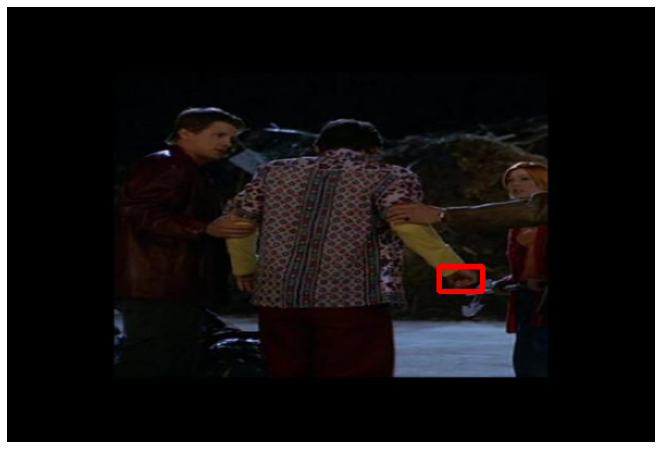

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sample_img = cv2.cvtColor(sample_img.astype('float32'), cv2.COLOR_BGR2RGB)
for box in boxes:
    cv2.rectangle(sample_img,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample_img)

In [32]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [33]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [34]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [35]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 15

In [36]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [37]:
# loss_hist = Averager()
# itr = 1

# for epoch in range(num_epochs):
#     loss_hist.reset()
    
#     for images, targets in train_data_loader:
#         model.train()
        
#         images = list(torch.from_numpy(image).float().to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         loss_dict = model(images, targets)

#         losses = sum(loss for loss in loss_dict.values())
#         loss_value = losses.item()

#         loss_hist.send(loss_value)

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         if itr % 50 == 0:
#             print(f"Iteration #{itr} loss: {loss_value}")

#         itr += 1
    
#     # update the learning rate
#     if lr_scheduler is not None:
#         lr_scheduler.step()

#     print(f"Epoch #{epoch} loss: {loss_hist.value}")   

In [38]:
# torch.save(model.state_dict(), 'frcnn400_1.pth')

### test

In [39]:
model.load_state_dict(torch.load('./frcnn400_1.pth'))
# model.to(device)

<All keys matched successfully>

In [40]:
test_ds = pd.DataFrame([{'filename': Path('D:/GeekBrains/pytorch/les06/data/hand_detect/test_image4.jpg'), 'class': 0, 'bbox': [[0, 0, 0, 0]]}])
test_ds

,filename,class,bbox
0,D:\GeekBrains\pytorch\les06\data\hand_detect\t...,0,"[[0, 0, 0, 0]]"


In [41]:
test_data = HandsDataset(test_ds['filename'], test_ds['bbox'], test_ds['class'], get_test_transform)

test_data_loader = DataLoader(
    test_data,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [42]:
images, targets = next(iter(test_data_loader))
images = list(torch.from_numpy(image).to(device = device, dtype = torch.float) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()
boxes

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


array([[0, 0, 0, 0]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


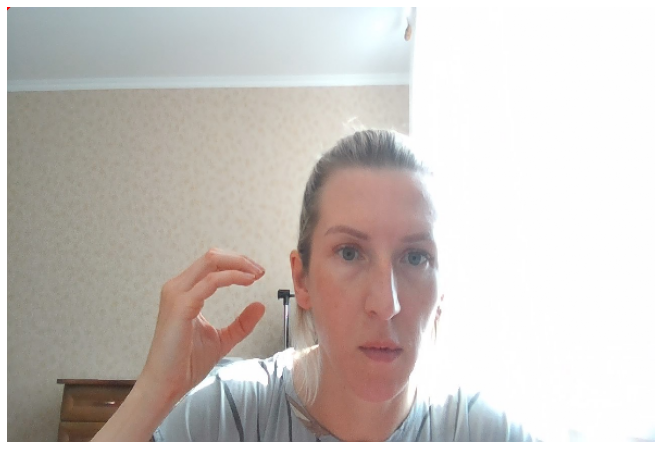

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sample = cv2.cvtColor(sample.astype('float32'), cv2.COLOR_BGR2RGB)
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [44]:
# model.to(device)
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
print(outputs)
outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
out_boxes = outputs[0]['boxes']
out_scores = outputs[0]['scores']

[{'boxes': tensor([[133.1719, 216.1127, 234.5621, 292.3674],
        [161.3532, 218.1638, 234.1292, 270.0078]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8091, 0.2314], device='cuda:0', grad_fn=<IndexBackward>)}]


In [45]:
# out_boxes.shape[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


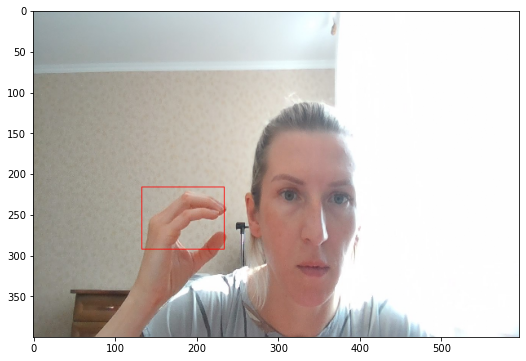

In [46]:
idx = 0
sample = images[idx].permute(1, 2, 0).cpu().numpy()
sample = cv2.cvtColor(sample.astype('float32'), cv2.COLOR_BGR2RGB)
scores = outputs[idx]['scores'].data.cpu().numpy()
max_score_idx = outputs[idx]['scores'].data.cpu().numpy().argmax()
boxes = outputs[idx]['boxes'].data.cpu().numpy().astype(int)
box = boxes[max_score_idx]

fig, ax = plt.subplots(1, 1, figsize = (12,6))
# for box in boxes:
#     print(box)
cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 1)
# ax.set_axis_off()
ax.imshow(sample)

In [47]:
def crop_faces(frame, boxes):
    faces = []
    for i, box in enumerate(boxes):
        faces.append(frame[int(box[1]-40):int(box[3]+40), int(box[0]-40):int(box[2]+40)])
    return faces

In [48]:
hand = crop_faces(sample, out_boxes)
hand

[array([[[0.6627451 , 0.6392157 , 0.5921569 ],
         [0.6627451 , 0.6392157 , 0.5921569 ],
         [0.654902  , 0.6313726 , 0.58431375],
         ...,
         [0.8       , 0.7921569 , 0.74509805],
         [0.63529414, 0.62352943, 0.5882353 ],
         [0.42352942, 0.41960785, 0.4       ]],
 
        [[0.6627451 , 0.6392157 , 0.5921569 ],
         [0.6745098 , 0.6509804 , 0.6039216 ],
         [0.67058825, 0.64705884, 0.6       ],
         ...,
         [0.7921569 , 0.78039217, 0.73333335],
         [0.5921569 , 0.5882353 , 0.5529412 ],
         [0.44313726, 0.4392157 , 0.41960785]],
 
        [[0.6627451 , 0.6392157 , 0.5921569 ],
         [0.68235296, 0.65882355, 0.6117647 ],
         [0.69803923, 0.6745098 , 0.62352943],
         ...,
         [0.7647059 , 0.7411765 , 0.69411767],
         [0.5568628 , 0.5411765 , 0.5058824 ],
         [0.44705883, 0.43529412, 0.41568628]],
 
        ...,
 
        [[0.6313726 , 0.6313726 , 0.58431375],
         [0.62352943, 0.62352943, 0.57647

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


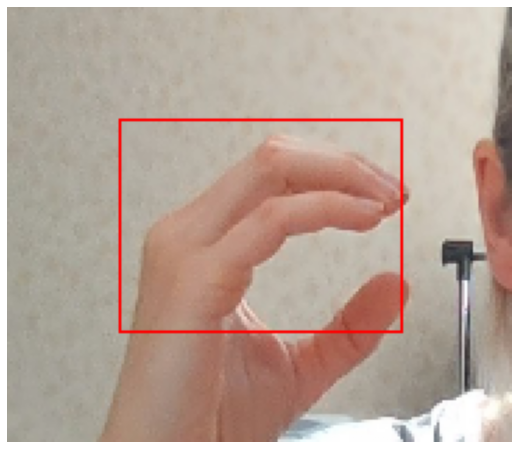

In [49]:
cropped_hand = hand[0]
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
   
ax.set_axis_off()
ax.imshow(cropped_hand)

In [50]:
%store cropped_hand

Stored 'cropped_hand' (ndarray)
